In [1]:
%load_ext autoreload
%autoreload 2
from corti.bezier_multirotor_planning import derive_bezier7, derive_bezier3
from corti.TimeOptBez import find_opt_multirotor_time

import numpy as np
import matplotlib.pyplot as plt

from cyecca.models.bezier import derive_ref, derive_eulerB321_to_quat, derive_multirotor
from cyecca.lie import SO3EulerB321, SO3Quat
import casadi as ca
from cyecca.models.rdd2 import (
    derive_position_control,
    derive_attitude_control,
    derive_attitude_rate_control,
)
from cyecca.models.rdd2_loglinear import derive_se23_error, derive_outerloop_control
from cyecca.models.rdd2 import derive_control_allocation
from cyecca.models.quadrotor import derive_model, sim

python:  /home/lylin/cognipilot/cranium/src/cyecca/.venv/bin/python
python:  /home/lylin/cognipilot/cranium/src/cyecca/.venv/bin/python


In [2]:
bezier7 = derive_bezier7()
bezier3 = derive_bezier3()
dt = 1e-2

# bezier boundary conditions
bc_t = np.array(
    [
        [  # position
            [0, 0, 0],  # wp0, x, y, z
            [0, 0, 2],  # wp0, x, y, z
            [0, -5, 2],
            [5, -5, 2],
            [5, 0, 2],
            [0, 0, 2],
            [0, 0, 2],
            [0, 0, 2],
            [0, 0, 2],
            [0, 0, 2],
            [0, 0, 2],
        ],
        [  # velocity
            [0, 0, 0],  # wp0, x, y, z
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
        ],
        [  # accel
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],  # wp0, x, y, z
        ],
        [  # jerk
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],  # wp0, x, y, z
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
        ],
    ]
)
bc_psi_list = np.array(
    [
        [  # attitude
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
        ],
        [  # angular velocity
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
        ],
    ]
)

# solve for bezier trajectories
k = 10
T0_list = []
PX_list = []
PY_list = []
PZ_list = []
Ppsi_list = []
for i in range(bc_t.shape[1] - 1):
    bc = bc_t[:, i : i + 2, :]
    bc_psi = bc_psi_list[:, i : i + 2, :]
    T0 = 5  # find_opt_multirotor_time(8, 4, bc, bc_psi, k, 1)[0]
    PX = np.array(bezier7["bezier7_solve"](bc[:, 0, 0], bc[:, 1, 0], T0)).reshape(-1)
    PY = np.array(bezier7["bezier7_solve"](bc[:, 0, 1], bc[:, 1, 1], T0)).reshape(-1)
    PZ = np.array(bezier7["bezier7_solve"](bc[:, 0, 2], bc[:, 1, 2], T0)).reshape(-1)
    Ppsi = np.array(
        bezier3["bezier3_solve"](bc_psi[:, 0, 2], bc_psi[:, 1, 2], T0)
    ).reshape(-1)
    T0_list.append(T0)
    PX_list.append(PX)
    PY_list.append(PY)
    PZ_list.append(PZ)
    Ppsi_list.append(Ppsi)

# generate trajectory
x_list = []
y_list = []
z_list = []
vx_list = []
vy_list = []
vz_list = []
ax_list = []
ay_list = []
az_list = []
jx_list = []
jy_list = []
jz_list = []
sx_list = []
sy_list = []
sz_list = []
psi_list = []
dpsi_list = []
ddpsi_list = []
t_list = []
for leg in range(len(T0_list)):
    n_t = 100
    t_leg = np.array([np.arange(0, T0_list[leg], dt)])
    traj_x = np.array(bezier7["bezier7_traj"](t_leg, T0_list[leg], PX_list[leg])).T
    traj_y = np.array(bezier7["bezier7_traj"](t_leg, T0_list[leg], PY_list[leg])).T
    traj_z = np.array(bezier7["bezier7_traj"](t_leg, T0_list[leg], PZ_list[leg])).T
    traj_psi = np.array(bezier3["bezier3_traj"](t_leg, T0_list[leg], Ppsi_list[leg])).T
    x = traj_x[:, 0]
    y = traj_y[:, 0]
    z = traj_z[:, 0]
    vx = traj_x[:, 1]
    vy = traj_y[:, 1]
    vz = traj_z[:, 1]
    ax = traj_x[:, 2]
    ay = traj_y[:, 2]
    az = traj_z[:, 2]
    jx = traj_x[:, 3]
    jy = traj_y[:, 3]
    jz = traj_z[:, 3]
    sx = traj_x[:, 4]
    sy = traj_y[:, 4]
    sz = traj_z[:, 4]
    psi = traj_psi[:, 0]
    dpsi = traj_psi[:, 1]
    ddpsi = traj_psi[:, 2]
    t = t_leg + leg * T0
    t_list.extend(t.reshape(-1))
    x_list.extend(x)
    y_list.extend(y)
    z_list.extend(z)
    vx_list.extend(vx)
    vy_list.extend(vy)
    vz_list.extend(vz)
    ax_list.extend(ax)
    ay_list.extend(ay)
    az_list.extend(az)
    jx_list.extend(jx)
    jy_list.extend(jy)
    jz_list.extend(jz)
    sx_list.extend(sx)
    sy_list.extend(sy)
    sz_list.extend(sz)
    psi_list.extend(psi)
    dpsi_list.extend(dpsi)
    ddpsi_list.extend(ddpsi)

In [3]:
f = derive_control_allocation()["f_alloc"]
f_euler_to_quat = derive_eulerB321_to_quat()["eulerB321_to_quat"]
f_multirotor = derive_multirotor()["bezier_multirotor"]
f_ref = derive_ref()["f_ref"]
model = derive_model()

In [4]:
x0_dict = model["x0_defaults"]
x0 = None
p = None
if x0 is not None:
    for k in x0.keys():
        if not k in x0_dict.keys():
            raise KeyError(k)
        x0_dict[k] = x0[k]
p_dict = model["p_defaults"]
if p is not None:
    for k in p.keys():
        if not k in p_dict.keys():
            raise KeyError(k)
        p_dict[k] = p[k]
x = np.array(list(x0_dict.values()), dtype=float)
p = np.array(list(p_dict.values()), dtype=float)
u = np.zeros(4, dtype=float)
t1 = 0
k_p_att = np.array([5, 5, 2], dtype=float)
leg = 0
CT = 8.54858e-06

thrust_trim = 2 * 9.8
# attitude rate
kp = np.array([0.3, 0.3, 0.05], dtype=float)
ki = np.array([0, 0, 0], dtype=float)
kd = np.array([0.1, 0.1, 0], dtype=float)
i0 = 0
e0 = np.zeros(3, dtype=float)  # error for attitude rate loop
de0 = np.zeros(3, dtype=float)  # deriv of att error (for lowpass)
f_cut = 10.0
i_max = np.array([0, 0, 0], dtype=float)
dae = model["dae"]
z_i = 0
pos_list = []
u_alloc_list = []
M_ff_list = []
thrust_ff_list = []
x_sp_list = []
y_sp_list = []
z_sp_list = []
v_sp_list = []
a_sp_list = []
j_sp_list = []
s_sp_list = []
motor_omega_list = []
t1_list = []
for i in range(len(t_list)):
    t = t_list[i]  # + 1e-11*np.random.randn()
    # t = t1
    if t > T0 * (leg + 1):
        leg += 1
    t_bezier = t - T0 * leg - dt / 2
    pw = np.array(
        [
            x[model["x_index"]["position_op_w_0"]],
            x[model["x_index"]["position_op_w_1"]],
            x[model["x_index"]["position_op_w_2"]],
        ]
    )
    vw = np.array(
        [
            x[model["x_index"]["velocity_w_p_b_0"]],
            x[model["x_index"]["velocity_w_p_b_1"]],
            x[model["x_index"]["velocity_w_p_b_2"]],
        ]
    )
    q = np.array(
        [
            x[model["x_index"]["quaternion_wb_0"]],
            x[model["x_index"]["quaternion_wb_1"]],
            x[model["x_index"]["quaternion_wb_2"]],
            x[model["x_index"]["quaternion_wb_3"]],
        ]
    )
    omega = np.array(
        [
            x[model["x_index"]["omega_wb_b_0"]],
            x[model["x_index"]["omega_wb_b_1"]],
            x[model["x_index"]["omega_wb_b_2"]],
        ]
    )
    [
        x_sp,
        y_sp,
        z_sp,
        psi_sp,
        dpsi_sp,
        ddpsi_sp,
        vw_sp,
        aw_sp,
        jw_sp,
        sw_sp,
    ] = f_multirotor(
        t_bezier, T0, PX_list[leg], PY_list[leg], PZ_list[leg], Ppsi_list[leg]
    )
    [_, q_sp, omega_ff, _, M_ff, thrust_ff] = f_ref(
        psi_sp, dpsi_sp, ddpsi_sp, vw_sp, aw_sp, jw_sp, sw_sp
    )
    u, Fp, Fm, Ft, Msat = f(100, 0.25 / ca.sqrt(2), 0.016, CT, thrust_ff, M_ff)

    try:
        f_int = ca.integrator("test", "idas", dae, t, t + dt)
        res = f_int(x0=x, z0=0, p=p, u=u)
    except RuntimeError as e:
        print(e)
        xdot = model["f"](x=x, u=u, p=p)
        print(xdot, x, u, p)
        raise e
    # print(i ,u)
    x = np.array(res["xf"]).reshape(-1)
    t1_list.append(t1)
    t1 += dt
    res["p"] = p_dict
    pos = x[0:3]
    motor_omega = x[13:]
    x_sp_list.append(np.array(x_sp).reshape(-1))
    y_sp_list.append(np.array(y_sp).reshape(-1))
    z_sp_list.append(np.array(z_sp).reshape(-1))
    v_sp_list.append(np.array(vw_sp).reshape(-1))
    a_sp_list.append(np.array(aw_sp).reshape(-1))
    j_sp_list.append(np.array(jw_sp).reshape(-1))
    s_sp_list.append(np.array(sw_sp).reshape(-1))
    pos_list.append(np.array(pos).reshape(-1))
    u_alloc_list.append(np.array(u).reshape(-1))
    motor_omega_list.append(np.array(motor_omega).reshape(-1))
    M_ff_list.append(np.array(M_ff).reshape(-1))
    thrust_ff_list.append(np.array(thrust_ff).reshape(-1))

TypeError: bad operand type for unary -: 'list'

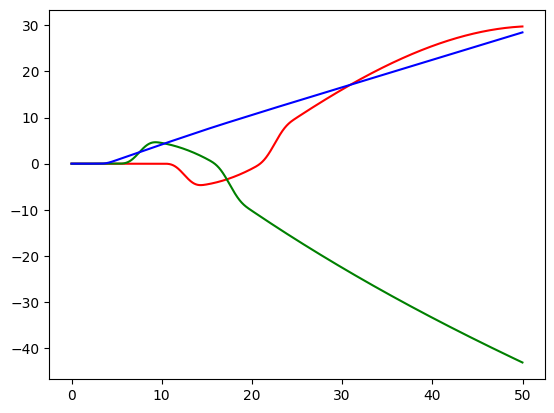

In [ ]:
t = np.arange(0, t_list[-1] + dt, dt)
plt.plot(t, np.array(pos_list)[:, 0], "r")
plt.plot(t, np.array(pos_list)[:, 1], "g")
plt.plot(t, np.array(pos_list)[:, 2], "b")

plt.plot(t, x_list, "r--")
plt.plot(t, y_list, "g--")
plt.plot(t, z_list, "b--")
plt.legend(["x", "y", "z", "xr", "yr", "zr"])

179.36200934444852
406.56597251911745
233.67393251501397


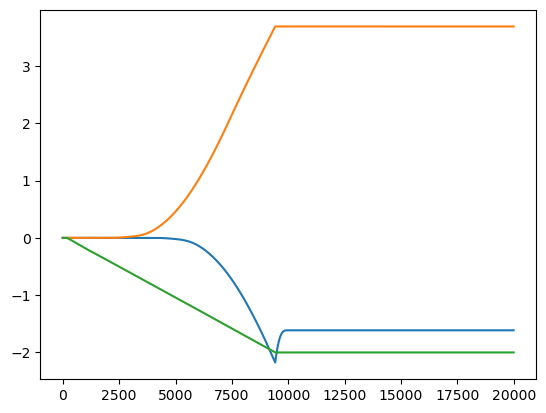

In [6]:
plt.plot(np.array(pos_list)[:, 0] - x_list)
plt.plot(np.array(pos_list)[:, 1] - y_list)
plt.plot(np.array(pos_list)[:, 2] - z_list)
print(np.linalg.norm(np.array(pos_list)[:, 0] - x_list))
print(np.linalg.norm(np.array(pos_list)[:, 1] - y_list))
print(np.linalg.norm(np.array(pos_list)[:, 2] - z_list))